In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import time
import numba
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt

from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from encoding import HierarchicalEncoder

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19"))

***
# Level 12

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data["sales"] = data.eval("y * sell_price")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 44 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ts_id             int16         
 1   item_id           int16         
 2   dept_id           int8          
 3   cat_id            int8          
 4   store_id          int8          
 5   state_id          int8          
 6   y                 int16         
 7   ds                datetime64[ns]
 8   snap_CA           int8          
 9   snap_TX           int8          
 10  snap_WI           int8          
 11  snap_CA_cum       int8          
 12  snap_TX_cum       int8          
 13  snap_WI_cum       int8          
 14  event_name_1      int8          
 15  sell_price        float32       
 16  regular_price     float32       
 17  price_iqr         float32       
 18  price_min         float32       
 19  price_max         float32       
 20  discount_norm     float32       
 21  price_

In [4]:
%%time
scales_by_level = compute_scales_by_level(scaling_input, valid_period[0])
weights_by_level = compute_weights_by_level(weighting_input, valid_period[0])

CPU times: user 1min 22s, sys: 22.9 s, total: 1min 45s
Wall time: 1min 45s


In [5]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':600,
    #'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**10-1,
    'learning_rate': 0.05,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    #"year_week",
    #"year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "no_stock_days",
    "sales",
]

categorical_features = {
    #"item_id": ("y", ce.GLMMEncoder, None),
    "item_id": "default",
    "store_id": "default",
    "state_id": "default",
    "dept_id": "default",
    "cat_id": "default",
    "event_name_1": "default",
    }

@numba.jit(nopython=True, nogil=True, fastmath=True)
def compute_nzeros(x):
    return np.sum(x==0)

@numba.jit(nopython=True, nogil=True, fastmath=True)
def compute_czeros(x):
    return np.sum(np.cumprod((x==0)[::-1]))/x.shape[0]

@numba.jit(nopython=True, nogil=True, fastmath=True)
def compute_sfreq(x):
    return np.sum(x!=0)/x.shape[0]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "window_functions":{
        "mean":   (None, [1,7,28], [7,14,21,28]),
        "median": (None, [1,7,14,28], [7,]),
        "std":    (None, [1,7,28], [7,28]),
        "kurt":   (None, [1,7,28], [7,28]),
        "czeros": (compute_czeros, [1,], [7,14,21,28,56]),
        "sfreq":  (compute_sfreq, [1,],  [7,14,21,28]),
    },
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["item_id","store_id"],
}

lagged_features_to_dropna = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features_to_dropna.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = list()
    for window_func,window_def in model_kwargs["window_functions"].items():
        _,window_shifts,window_sizes = window_def
        if window_func in ["mean","median","std","min","max"]:
            rw_features.extend([f"{window_func}{window_size}_shift{window_shift}"
                                for window_size in window_sizes
                                for window_shift in window_shifts])
    lagged_features_to_dropna.extend(rw_features)

***
## training without early stopping

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Building the features
Elapsed time: 9.095927973588308 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.845489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8691
[LightGBM] [Info] Number of data points in the train set: 34006633, number of used features: 82
Elapsed time: 30.308648200829825 [min]
Predicting
Elapsed time: 14.04431779384613 [min]
wrmsse: 0.7378266762827308
wrmsseL12: 0.8496077103913805
{'root': 0.5970636764939811, ('state_id',): 0.6429178734040858, ('store_id',): 0.7430563676052153, ('cat_id',): 0.6

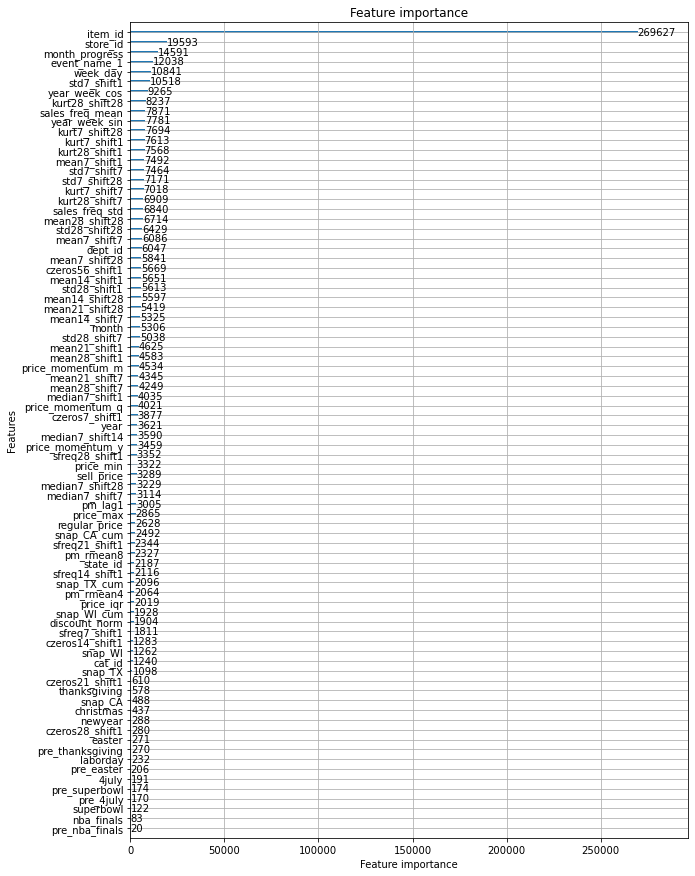

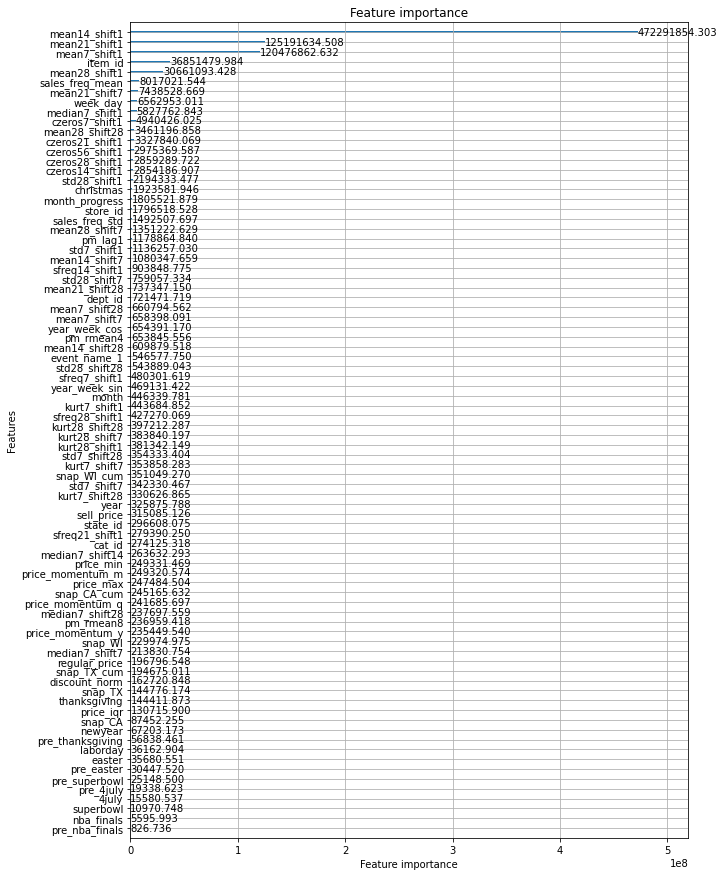

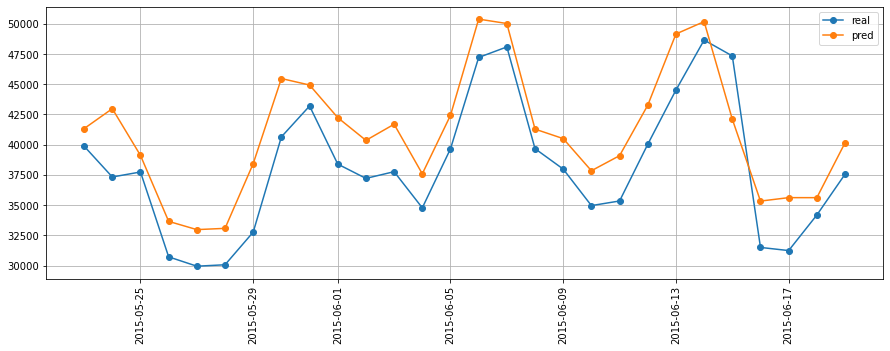

CPU times: user 7h 59min 11s, sys: 1h 2min 13s, total: 9h 1min 25s
Wall time: 53min 42s


36572

In [6]:
%%time

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds < @valid_start").reset_index(drop=True)

print("Building the features")
tic = time.time()
model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data)
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
gc.collect()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

ts_id_in_train = model_level12.train_features.ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

print("Fitting the model")
tic = time.time()
model_level12.fit()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

print("Predicting")
tic = time.time()
forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Building the features
Elapsed time: 6.690314507484436 [min]
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.805199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7845
[LightGBM] [Info] Number of data points in the train set: 34006633, number of used features: 57
Elapsed time: 33.997829882303876 [min]
Predicting
Elapsed time: 13.392801888783772 [min]
wrmsse: 0.6603792580406646
wrmsseL12: 0.8481289218947603
{'root': 0.44076602139169674, ('state_id',): 0.5275866972471274, ('store_id',): 0.6386230418035659, ('cat_id',): 0

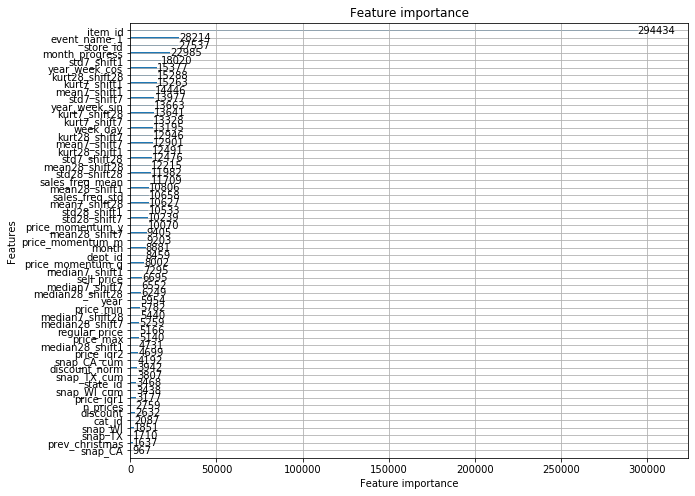

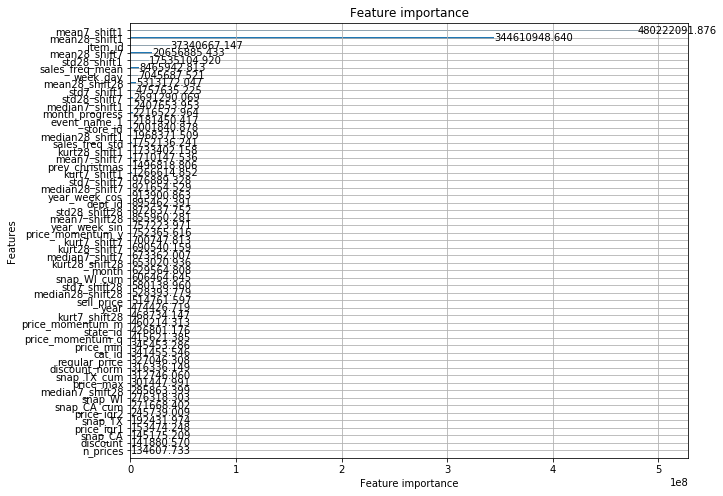

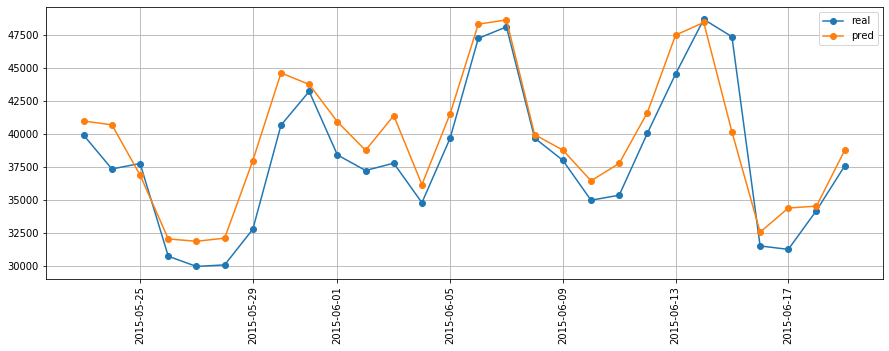

CPU times: user 9h 16min 42s, sys: 1h 15min 38s, total: 10h 32min 20s
Wall time: 54min 25s


27417

In [6]:
%%time 

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds < @valid_start").reset_index(drop=True)

print("Building the features")
tic = time.time()
model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data)
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

ts_id_in_train = model_level12.train_features.ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_train")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

print("Fitting the model")
tic = time.time()
model_level12.fit()
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

print("Predicting")
tic = time.time()
forecast = model_level12.predict(valid_data.drop("y", axis=1), recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator.eval1._evaluate(forecast.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(forecast.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

mrg = (valid_data.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

***
## training with early stopping

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.689731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8729
[LightGBM] [Info] Number of data points in the train set: 18478187, number of used features: 71
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.762084	valid_0's wrmsse: 0.974714
[50]	valid_0's wrmsseL12: 0.700601	valid_0's wrmsse: 0.666661
[75]	valid_0's wrmsseL12: 0.69061	valid_0's wrmsse: 0.600347
[100]	valid_0's wrmsseL12: 0.688025	valid_0's wrmsse: 0.571237
[125]	vali

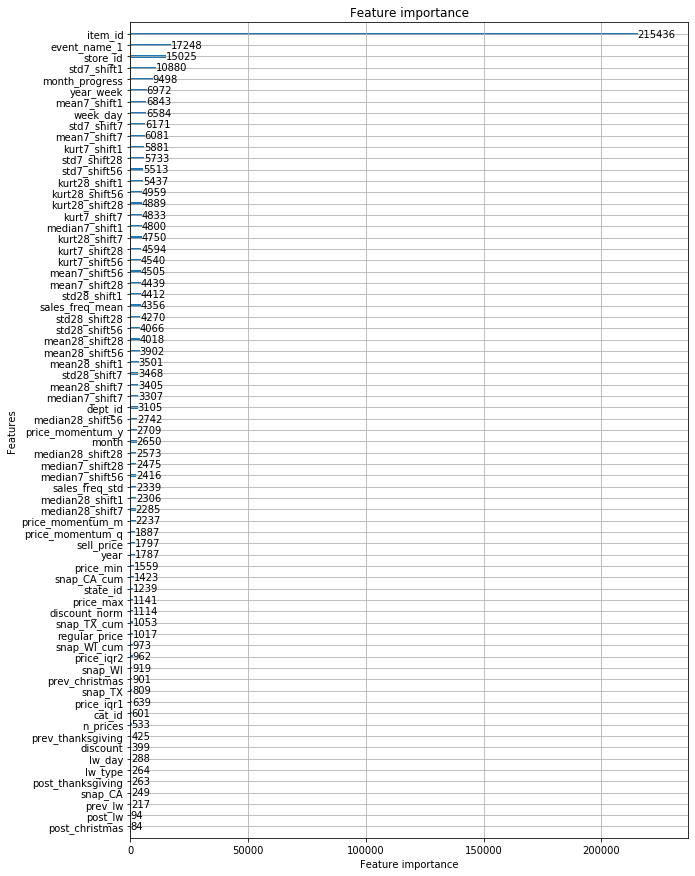

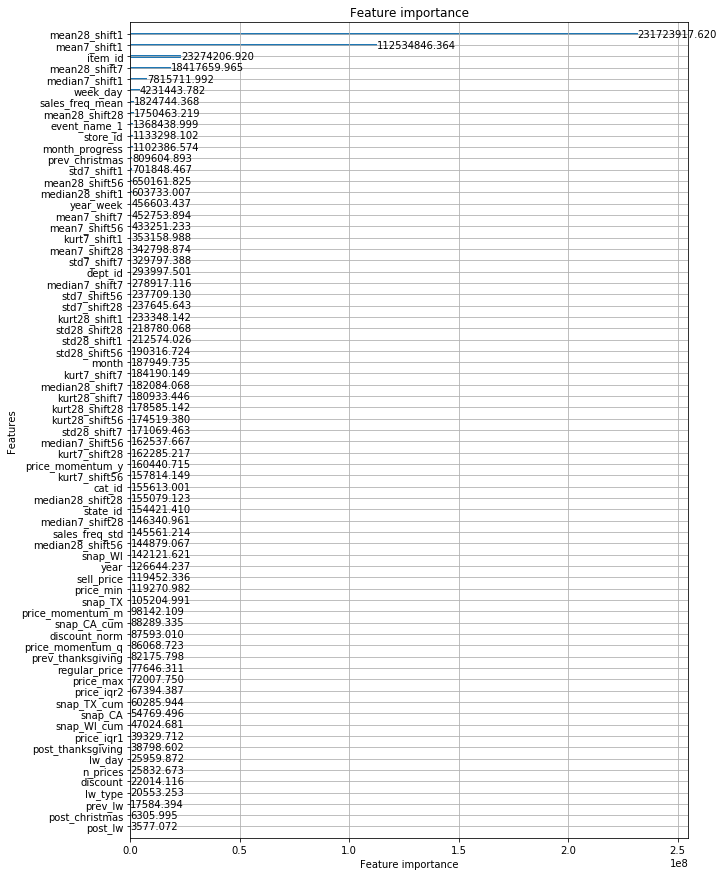

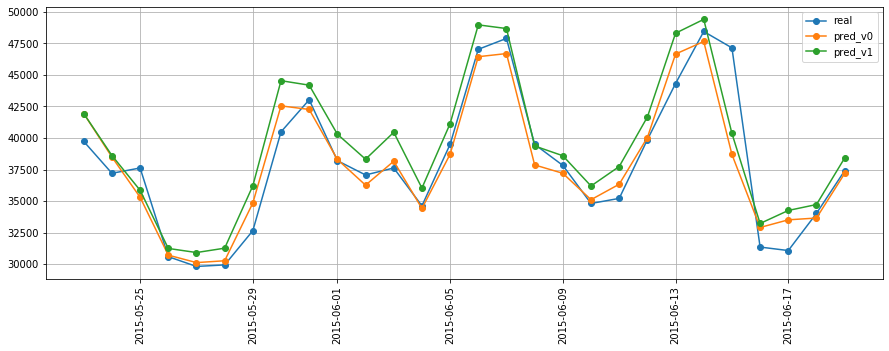

CPU times: user 8h 11min 57s, sys: 1h 36min 4s, total: 9h 48min 1s
Wall time: 1h 43min 9s


32642

In [8]:
%%time

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
ts_id_in_train = model_level12.train_features.ts_id.unique()
model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

print("Fitting the model")
tic = time.time()
evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

valid_dataframe = (model_level12.valid_features
                   .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                   .copy())
evaluator = WRMSSEEvaluator(valid_dataframe)

print("Predicting with ground thruth lagged values")
tic = time.time()
forecast_v0 = (model_level12.valid_features
                  .loc[:, ["ds"]+model_level12.ts_uid_columns]
                  .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_v0.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_v1 = model_level12.predict(valid_data, recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_v1.y_pred.values)
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

***